In [1]:
!pip install livelossplot

In [2]:
import random, os, glob # default python modules that let me randomise and manipulate files
import numpy as np # for data manipulation through arrays
import tensorflow as tf
from keras.models import Sequential # the model I will use
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D # layers I will incorporate
from keras.callbacks import EarlyStopping # for better training
from tensorflow.keras.applications import VGG19 # transfer learning model
from keras import backend
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
import librosa # to demonstrate the creation of a mel spectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def setRandom():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


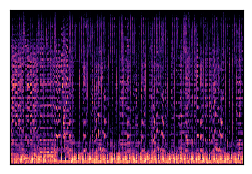

In [ ]:
# an example file
filePath="/content/drive/MyDrive/Data/genres_original/disco/disco.00003.wav"

file, samplingRate = librosa.load(filePath)
example, _ = librosa.effects.trim(file)

hopLength = 512 # the number of samples between successive columns of the spectrogram

spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)

plt.figure(figsize = (3, 2))
librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
ipd.Audio(example, rate = samplingRate)

In [ ]:
source = "/content/drive/MyDrive/Data/images_original" # source folder path
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] # list with the genre folder names

for genre in genres: # iterate through each genre folder
    path = os.path.join(source, genre)
    if not os.path.isdir(path):
        print(f"Skipping {genre} folder as it does not exist.")
        continue
    pngs = [i for i in os.listdir(path) if i[-4:] == ".png"] # get a list of .png files in the genre folder
    print(f"Size of {genre} dataset: {len(pngs)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


In [ ]:
setRandom()
split = [80, 9, 10]
train, val, test = {}, {}, {} # empty dictionaries to store the filepaths
trainLen, valLen, testLen = {}, {}, {} # empty dictionaries to store the number of files under each genre for each dataset
dictionaries = [train, val, test]

for d in dictionaries:
    if d == train: num = slice(0, split[0])
    elif d == val: num = slice(split[0], split[0] + split[1])
    else: num = slice(split[0] + split[1], split[0] + split[1] + split[2])
    for genre in genres: # iterate through each genre folder
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png")) # get a list of .png filepaths in the genre folder
        selected = pngs[num] # take the first 80 files
        d[genre] = selected # store the selected files in the dictionary

lenDictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]
print(f"\033[1mTraining:\033[0m {lenDictionaries[0]}")
print(f"\033[1mValidation:\033[0m {lenDictionaries[1]}")
print(f"\033[1mTest:\033[0m {lenDictionaries[2]}")

Training: {'blues': 80, 'classical': 80, 'country': 80, 'disco': 80, 'hiphop': 80, 'jazz': 80, 'metal': 80, 'pop': 80, 'reggae': 80, 'rock': 80}
Validation: {'blues': 9, 'classical': 9, 'country': 9, 'disco': 9, 'hiphop': 9, 'jazz': 9, 'metal': 9, 'pop': 9, 'reggae': 9, 'rock': 9}
Test: {'blues': 10, 'classical': 10, 'country': 10, 'disco': 10, 'hiphop': 10, 'jazz': 10, 'metal': 10, 'pop': 10, 'reggae': 10, 'rock': 10}


In [ ]:
batchSize = 32 # typical batch size for a neural network
genreMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverseGenreMap = {value: key for key, value in genreMap.items()}

def createDataset(d):
    imgSize = (288, 432) # define image and batch parameters
    imageList, labelList = [], [] # create lists to store images and labels
    for genre, paths in d.items():
        for path in paths:
            image = tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels = 3), imgSize), tf.float32) / 255.0 # normalise pixel values between 0 and 1 (preprocessing!)
            imageList.append(image)
            labelList.append(genreMap[genre]) # convert genre to its integer label

    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList)).shuffle(buffer_size=len(imageList)).batch(batchSize) # create and return tensorflow dataset
    return(dataset)

def prep(ds):
    out = (
        ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)) # modifies the image tensor's data type to floats
        .cache() # cache dataset elements in memory or on disk to speed up data loading
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # prefetch dataset elements in the background and automatically optimise data loading
        )
    return out # return the prepared and optimised dataset

training, validation, testing = prep(createDataset(train)), prep(createDataset(val)), prep(createDataset(test))
print("Datasets created.") # to let me know when it's finished running (:

Datasets created.


Training Examples:


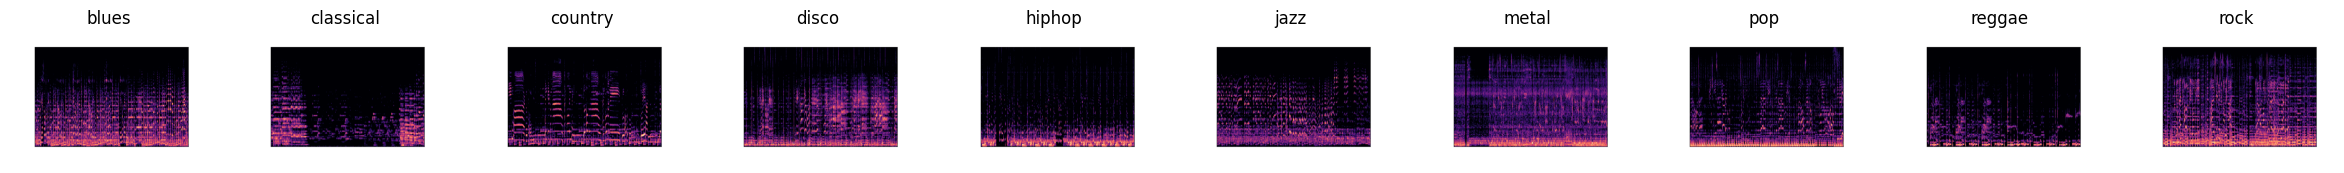

Validation Examples:


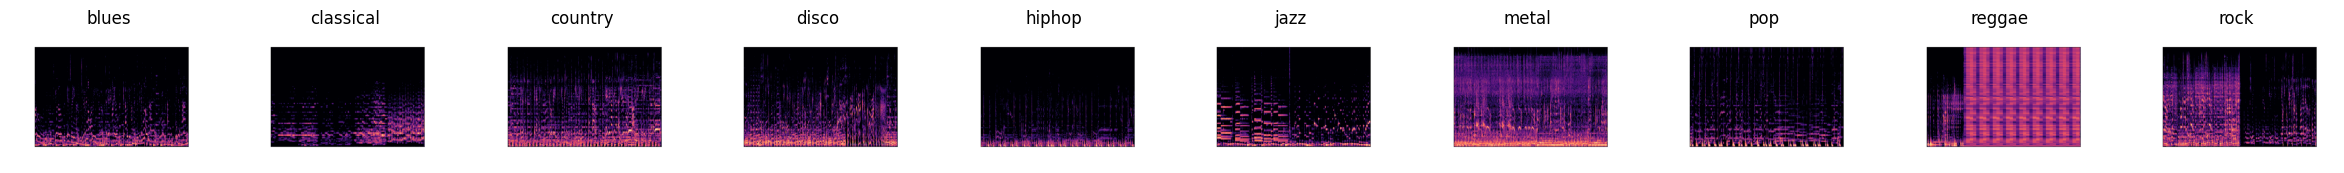

Testing Examples:


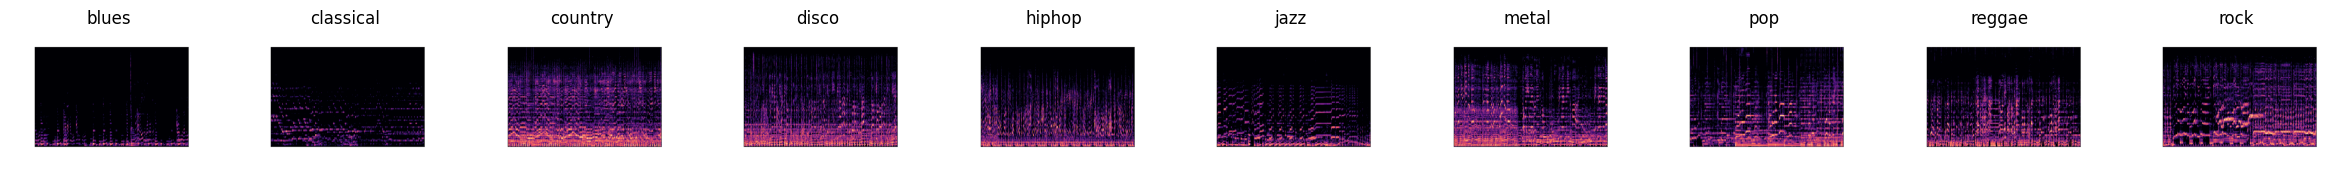

In [ ]:
def view_dataset(dataset):
    genreExamples = {}  # dictionary to store examples for each label

    for images, labels in dataset:
        for image, label in zip(images, labels):
            label = int(label.numpy())  # convert label tensor to integer
            if label not in genreExamples:
                genreExamples[label] = image

        if len(genreExamples) == len(genres):
            break

    # display the randomly chosen examples
    plt.figure(figsize = (30, 20))
    for label, image in genreExamples.items():
        ax = plt.subplot(1, len(genres), label + 1)
        plt.imshow(image)
        plt.title(inverseGenreMap[label])
        plt.axis("off")
    plt.show()

print("\033[1mTraining Examples:\033[0m"); view_dataset(training) # shows a labelled example of a mel spectrogram from each genre from each dataset
print("\033[1mValidation Examples:\033[0m"); view_dataset(validation)
print("\033[1mTesting Examples:\033[0m"); view_dataset(testing)

In [ ]:
inputShape = [288, 432, 3] # the shape of the images (288px tall, 432px wide, and 3 colour channels/RGB)

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

In [ ]:
from tensorflow.keras.applications import InceptionV3 # transfer learning model
baseModel = InceptionV3(input_shape = inputShape, weights = "imagenet", include_top = False, pooling = "avg")

for layer in baseModel.layers:
    layer.trainable = False # freeze the pre-trained layers

transfer = Sequential([
    baseModel,

    Flatten(),
    BatchNormalization(),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(256, activation = "relu"),
    Dropout(0.3), # dropout layer to prevent overfitting
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(len(genres), activation = "softmax")
])
transfer.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
transfer.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,025,578 (87.84 MB)

 Trainable params: 1,218,698 (4.65 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [ ]:
cnn = Sequential([
    BatchNormalization(input_shape = inputShape),

    Conv2D(32, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(128, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(256, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(512, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(genres), activation = "softmax")
])
cnn.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # "sparse_categorical_crossentropy" because labels are integers
cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_95               │ (None, 288, 432, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 286, 430, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 143, 215, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 141, 213, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 70, 106, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 68, 104, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 32, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 14, 23, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 11, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 39424)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      40,371,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,471,766 (162.02 MB)

 Trainable params: 42,470,736 (162.01 MB)

 Non-trainable params: 1,030 (4.02 KB)

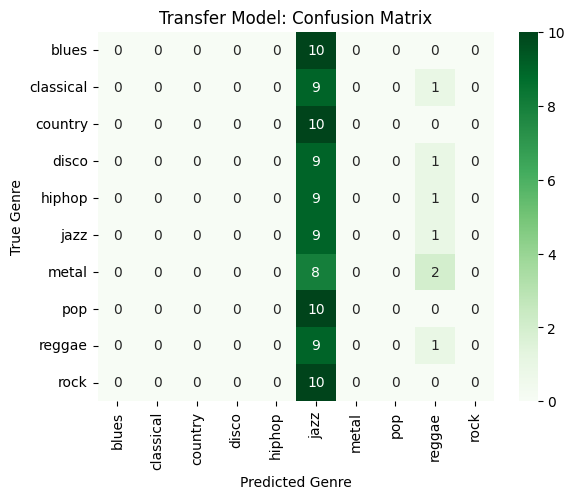

Transfer Model
Training Accuracy: 89.75% 
Train Loss: 2.3431

Validation Accuracy: 92.2222% 
Test Loss: 2.3342

Testing Accuracy: 90.0% 
Test Loss: 2.3419


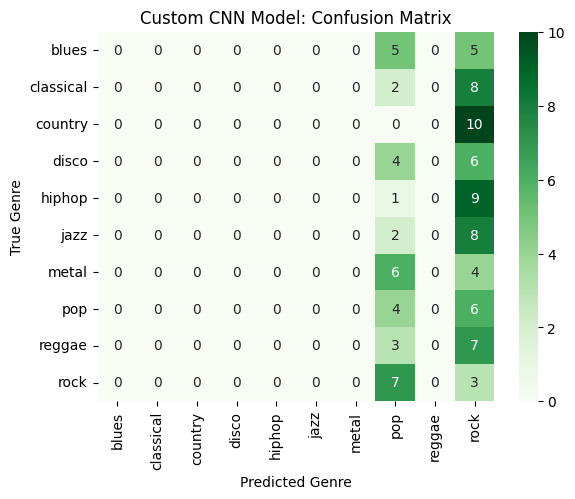

Custom CNN Model
Training Accuracy: 90.5% 
Train Loss: 2.3018

Validation Accuracy: 90.0% 
Test Loss: 2.3015

Testing Accuracy: 93.0% 
Test Loss: 2.302


In [ ]:
def confusionMatrix(model, name):
    trueLabels = np.concatenate([y for x, y in testing], axis = 0) # get the true labels from the testing dataset

    predictedLabels = np.argmax(model.predict(testing, verbose = 0), axis = 1) # get the predicted labels from the model

    matrix = confusion_matrix(trueLabels, predictedLabels) # create the confusion matrix

    plt.figure() # plot the confusion matrix using seaborn for the heatmap
    sns.heatmap(matrix, annot = True, cmap = "Greens", xticklabels = genres, yticklabels = genres)
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.title(f"{name} Model: Confusion Matrix")
    plt.show()

    trainStats, valStats, testStats = model.evaluate(training, verbose = 0), model.evaluate(validation, verbose = 0), model.evaluate(testing, verbose = 0)
    print(f"\033[1m{name} Model\033[0m")
    print(f"Training Accuracy: {100-(round(trainStats[1] * 100, 4))}% \nTrain Loss: {round(trainStats[0], 4)}\n")
    print(f"Validation Accuracy: {100-(round(valStats[1] * 100, 4))}% \nTest Loss: {round(valStats[0], 4)}\n")
    print(f"Testing Accuracy: {100-(round(testStats[1] * 100, 4))}% \nTest Loss: {round(testStats[0], 4)}")


confusionMatrix(transfer, "Transfer")
confusionMatrix(cnn, "Custom CNN")

In [ ]:
setRandom()
genre, paths = random.choice(list(test.items())) # chooses a random genre and corresponding list of paths
path = paths[random.randint(0, len(paths) - 1)] # chooses a random path within that list
soundPath = f"{path[:-4]}.wav".replace("images_original", "genres_original") # creates a new variable for the image path's respective audio file path
soundPath = soundPath[:-9] + "." + soundPath[-9:]

image = tf.image.decode_png(tf.io.read_file(path), channels = 3)
image = tf.image.resize(image, inputShape[:2])  # resize the image to the input shape of the model
image = tf.cast(image, tf.float32) / 255.0 # normalise pixel values
image = np.expand_dims(image, axis = 0) # expand dimensions to match the batch size (even though it's just one image)

predictions = cnn.predict(image) # make a prediction using the custom cnn model
predictedGenre = inverseGenreMap[np.argmax(predictions)] # get the predicted class label

print(f"\033[1mPredicted genre:\033[0m {genre}")
print(f"\033[1mActual genre:\033[0m {genre}")
print(f"\033[1mFilepath:\033[0m {soundPath[71:]}")
ipd.Audio(soundPath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Predicted genre: metal
Actual genre: metal
Filepath: 
